In [1]:
import numpy as np
import h5py
import netCDF4 as nc
import oceanDAS as odas
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, datetime, timezone
from scipy import signal
import xarray as xr

%matplotlib inline
%cd -q '/Users/hglover/Library/CloudStorage/Box-Box/FiberExperiments/DAScomparison_paper/'

plt.rc('font', size=12)
h, f_noise, clrs = odas.all_line_info()


In [2]:
def calc_Dspec(das,dasTime,t1,C,C_frq):
    fs = 1/(dasTime[1]-dasTime[0])
    das = das[(dasTime>=t1) & (dasTime<(t1+60*60))]
    frq,psd_das = signal.welch(das,fs=fs,window='hann',nperseg=fs*60*5,detrend=False)

    # correct from PSD of strain to PSD of pressure
    C = np.interp(frq,C_frq,C)
    psd_dasp = C*psd_das
    
    return frq, psd_das, psd_dasp
def calc_Pspec(press,presTime,t1):
    fs = 1/(presTime[1]-presTime[0])
    press = press[(presTime>=t1) & (presTime<(t1+60*60))]
    frq,psd = signal.welch(press,fs=fs,window='hann',nperseg=fs*60*5,detrend=False)

    return frq, psd

def calc_nrmse(ctrl,pred):
    nrmse = np.sqrt(np.nanmean((ctrl-pred)**2,axis=0))
    nrmse = nrmse/(np.max(ctrl,axis=0))
#     nrmse = nrmse/np.nanmean(ctrl,axis=0)
    return nrmse
ci95 = [0.62018211,1.87808281]

In [3]:
# Duck
pname = 'DuckNC_Glover/'

t1 = datetime(2021, 11, 12, 0, 0, 0,tzinfo=timezone.utc).timestamp()
# load pressure
with np.load(pname+'FRF-ocean_waveTs_awac-11m_202111.npz') as data:
    press = data['p']
    presTime = data['t']

# load strain
f = h5py.File(pname + 'ChNo436_Nov2021fromdown.hdf5', 'r') 
dasTime = f['Acquisition']['RawDataTime'][:]
das = f['Acquisition']['RawData'][:] # unit of E

# load correction factor
with np.load(pname+'empCalNov_all.npz') as data:
    C_frq = data['x']
    C = data['y'][381,:]

# calculate spectra every 30 mins 
numvals = 60*30
t1 = datetime(2021, 11, 12, 0, 0, 0,tzinfo=timezone.utc).timestamp()
t2 = datetime(2021, 11, 30, 23, 30, 0,tzinfo=timezone.utc).timestamp()
idx = np.arange(t1,t2,60*60)
L = len(idx)
# calc first round (plot in examples)
frq_p0, psd_p = calc_Pspec(press,presTime,t1)
frq_d, psd_d, psd_dp = calc_Dspec(das,dasTime,t1,C,C_frq)
psd_dp = np.interp(frq_p0,frq_d,psd_dp)

for jj in range(1,L):
    f, _, temp = calc_Dspec(das,dasTime,idx[jj],C,C_frq)
    psd_dp = np.vstack([psd_dp,np.interp(frq_p0,f,temp)]) #time,freq
    _, temp = calc_Pspec(press,presTime,idx[jj])
    psd_p = np.vstack([psd_p,temp])

nrmse0 = calc_nrmse(psd_p,psd_dp)


# make the figure
plt.ioff()
fig,ax = plt.subplots(7,1,figsize=(10,20))
ax = ax.ravel()

# plot example with close calibration point
jj=0
ax[jj].plot(frq_d,psd_d,'b',linewidth=2)
ax[jj].fill_between(frq_d,psd_d*ci95[0], psd_d*ci95[1],alpha=0.3, facecolor='b')

ax2 = ax[jj].twinx()
ax2.fill_between(frq_p0,psd_dp[0,:]*ci95[0], psd_dp[0,:]*ci95[1],alpha=0.3, facecolor='tab:gray')
ax2.fill_between(frq_p0,psd_p[0,:]*ci95[0], psd_p[0,:]*ci95[1],alpha=0.3, facecolor='k')
ax2.plot(frq_p0,psd_dp[0,:],c = 'tab:gray',linewidth=2,linestyle='--')
ax2.plot(frq_p0,psd_p[0,:],c = 'k',linewidth=2.5)
ax2.set_ylim([1e-5,5])
ax[jj].set_ylim([3e-14,3e-10])
ax2.set_yscale('log')
ax2.set_ylabel('PSD ($m^2$/Hz)')


Text(0, 0.5, 'PSD ($m^2$/Hz)')

In [4]:
# KNO
pname = 'KNO_Glover/'

# load pressure
with np.load(pname + 'rbr_pres_temp_all.npz') as data:
    press = data['p'][:,5] #5 is nearest ch124, h=11.5 m
    presTime = data['tvec']

# load strain data
with np.load(pname+'filtstrain_F1_ch124.npz') as data:
    das = data['e']
    dasTime = data['t']

# load correction factor for chno = 124, Fiber 1,
with np.load(pname+'empCal_all_F1.npz') as data:
    C_frq = data['frq']
    C = data['sf'][124-40,:].flatten()

# calculate spectra every 30 mins 
numvals = 60*30
t1 = datetime(2023, 1, 17, 4, 0, 0,tzinfo=timezone.utc).timestamp()
t2 = datetime(2023, 1, 20, 0, 0, 0,tzinfo=timezone.utc).timestamp()
idx = np.arange(t1,t2,60*60)
L = len(idx)
# calc first round (plot in examples)
frq_p1, psd_p = calc_Pspec(press,presTime,t1)
frq_d, psd_d, psd_dp = calc_Dspec(das,dasTime,t1,C,C_frq)
psd_dp = np.interp(frq_p1,frq_d,psd_dp)

for jj in range(1,L):
    f, _, temp = calc_Dspec(das,dasTime,idx[jj],C,C_frq)
    psd_dp = np.vstack([psd_dp,np.interp(frq_p1,f,temp)]) #time,freq
    _, temp = calc_Pspec(press,presTime,idx[jj])
    psd_p = np.vstack([psd_p,temp])

nrmse1 = calc_nrmse(psd_p,psd_dp)


# plot example with close calibration point
jj = 1
ax[jj].plot(frq_d,psd_d,'b',linewidth=2)
ax[jj].fill_between(frq_d,psd_d*ci95[0], psd_d*ci95[1],alpha=0.3, facecolor='b')

ax2 = ax[jj].twinx()
ax2.fill_between(frq_p1,psd_dp[0,:]*ci95[0], psd_dp[0,:]*ci95[1],alpha=0.3, facecolor='tab:gray')
ax2.fill_between(frq_p1,psd_p[0,:]*ci95[0], psd_p[0,:]*ci95[1],alpha=0.3, facecolor='k')

ax2.plot(frq_p1,psd_dp[0,:],c = 'tab:gray',linewidth=2,linestyle='--')
ax2.plot(frq_p1,psd_p[0,:],c = 'k',linewidth=2.5)
ax2.set_ylim([1e-5,5])
ax[jj].set_ylim([1e-14,6e-12])
ax2.set_ylabel('PSD ($m^2$/Hz)')
ax2.set_yscale('log')




In [5]:
# Marthas Vineyard

pname = 'MarthasVineyard_Smith/'
das = nc.Dataset(pname+'mvco_2022-12_waveoutputs_nch2112.nc')
t1 = datetime(2022, 12, 21, 21, 0, 0,tzinfo=timezone.utc).timestamp()
dt = 30*60
time_mv = np.arange(t1,t1+(dt*len(das['time'])),dt)
chn = das['channels'][:]
frq_p2 = das['frequency'][:]
ns = len(time_mv)

adcp = nc.Dataset(pname+'mvco_adcp_202211_allwaveoutputs.nc')
t1 = datetime(2022, 12, 5, 15, 0, 0,tzinfo=timezone.utc).timestamp()
dt = 15*60
time_adcp = np.arange(t1,t1+(dt*len(adcp['time'])),dt)

psd_p = np.empty([ns,len(frq_p2)])
psd_d = np.empty([ns,len(frq_p2)])
psd_dp = np.empty([ns,len(frq_p2)])
for jj in range(ns):
    temp = adcp['E'][time_adcp==time_mv[jj],:].flatten()
    psd_p[jj,:] = np.interp(frq_p2,adcp['frequency'][:],temp)
    psd_d[jj,:] = das['E'][jj ,chn==2100,:].flatten()
    psd_dp[jj,:] = das['E_corr'][jj ,chn==2100,:].flatten()

nrmse2 = calc_nrmse(psd_p,psd_dp)

# plot example with close calibration point
t_idx = 95
jj=2
ax[jj].plot(frq_p2,psd_d[t_idx,:],'b',linewidth=2)
ax[jj].fill_between(frq_p2,psd_d[t_idx,:]*ci95[0], psd_d[t_idx,:]*ci95[1],alpha=0.3, facecolor='b')

ax2 = ax[jj].twinx()
ax2.fill_between(frq_p2,psd_dp[t_idx,:]*ci95[0], psd_dp[t_idx,:]*ci95[1],alpha=0.3, facecolor='tab:gray')
ax2.fill_between(frq_p2,psd_p[t_idx,:]*ci95[0], psd_p[t_idx,:]*ci95[1],alpha=0.3, facecolor='k')
ax2.plot(frq_p2,psd_dp[t_idx,:],c = 'tab:gray',linewidth=2,linestyle='--')
ax2.plot(frq_p2,psd_p[t_idx,:],c = 'k',linewidth=2.5)
ax2.set_ylim([1e-4,50])
# # ax[jj].set_ylim([3e-14,3e-10])
ax2.set_yscale('log')
ax2.set_ylabel('PSD ($m^2$/Hz)')


Text(0, 0.5, 'PSD ($m^2$/Hz)')

In [6]:
# Oliktok
pname = 'OliktokPoint_Smith/'

das = nc.Dataset(pname+'CODAS_2022-08_DASwaveoutputs_v230612.nc')
t1 = datetime(2022, 8, 17, 0, 0, 0,tzinfo=timezone.utc).timestamp()
dt = 3600
time_das = np.arange(t1,t1+(dt*len(das['time'])),dt)
frq_p3 = das['frequency'][:]
ns = len(time_das)

swft = nc.Dataset(pname+'SWIFT18_OliktokPt_Aug2022_reprocessedIMU_1Hzspectra_convertedTe.nc')
t1 = datetime(2022, 8, 13, 23, 0, 0,tzinfo=timezone.utc).timestamp()

time_swft = np.arange(t1,t1+(dt*len(swft['time'])),dt)

# Calculate depth attenuation function to translate buoy surface to pressure at bed 
k = (2*np.pi*frq_p3)**2 / 9.8
attenuation = np.exp(-k*12)
attenuation = attenuation**2
# attenuation[attenuation>500]=500


psd_p = np.empty([ns,len(frq_p3)])
psd_d = np.empty([ns,len(frq_p3)])
psd_dp = np.empty([ns,len(frq_p3)])
for jj in range(ns):
    idx = np.argmin(np.abs(time_swft-time_das[jj]))
    temp = swft['energy'][idx,:].flatten()
    psd_p[jj,:] = np.interp(frq_p3,swft['freq'][:],temp)#*attenuation
    psd_d[jj,:] = das['E'][400,jj,:].flatten()
    psd_dp[jj,:] = das['E_corr'][400,jj,:].flatten()#*attenuation


nrmse3 = calc_nrmse(psd_p,psd_dp)



# plot example with close calibration point
t_idx = 95
jj=3
ax[jj].plot(frq_p3,psd_d[t_idx,:],'b',linewidth=2)
ax[jj].fill_between(frq_p3,psd_d[t_idx,:]*ci95[0], psd_d[t_idx,:]*ci95[1],alpha=0.3, facecolor='b')

ax2 = ax[jj].twinx()
ax2.fill_between(frq_p3,psd_dp[t_idx,:]*ci95[0], psd_dp[t_idx,:]*ci95[1],alpha=0.3, facecolor='tab:gray')
ax2.fill_between(frq_p3,psd_p[t_idx,:]*ci95[0], psd_p[t_idx,:]*ci95[1],alpha=0.3, facecolor='k')
ax2.plot(frq_p3,psd_dp[t_idx,:],c = 'tab:gray',linewidth=2,linestyle='--')
ax2.plot(frq_p3,psd_p[t_idx,:],c = 'k',linewidth=2.5)
ax2.set_ylim([1e-5,5])
# ax[jj].set_ylim([3e-14,3e-10])
ax2.set_yscale('log')
ax2.set_ylabel('PSD ($m^2$/Hz)')


Text(0, 0.5, 'PSD ($m^2$/Hz)')

In [7]:
# Homer
pname = 'HomerAK_Williams/'

# load ground truth spectra:
with h5py.File(pname+'NDBC-46108_spectra.h5','r') as fp:
    sdate = fp['DATE'][:]/1e9 # POSIX time stamp (s) (convert from ns to s)
    frq_p4 = fp['FREQ'][:] # Hz
    psd_p = fp['SPEC'][:] # m^2/Hz
nt = len(sdate)     # number of buoy spectra

# Calculate depth attenuation function to translate buoy surface to pressure at bed 
k = (2*np.pi*frq_p4)**2 / 9.8
attenuation = np.exp(k*40)
attenuation = attenuation**2
attenuation[attenuation>500]=500
# psd_p = psd_p/attenuation

# load strain at all channels  then pull out channel 31
fname = 'GCI_TERRA_2p5Hz_data.h5'
onechn = False
rawstrain,das_time,chnl,depth,metadata = odas.loadHomer(pname,fname,onechn)
rawstrain = rawstrain[~np.isnan(das_time),31]
das_time = das_time[~np.isnan(das_time)]
depth = depth[31]

ns = len(rawstrain)

# Calculate strain spectra corresponding to each buoy spectra
nns = int(200*metadata['fs'])   # number of samples for each FFT (to match buoy resolution)
nsg = int(30*60*metadata['fs']) # number of samples in each window

# calculate correction factor for each point in time
ss = np.zeros((nt,len(frq_p4)))
psd_d = np.zeros((nt,len(frq_p4)))
for it in range(nt):
    ii = np.argmin(abs(sdate[it]-das_time))
    i1 = np.maximum(0,ii-nsg//2)
    i2 = np.minimum(ns,ii+nsg//2)
    frq_d,temp = signal.welch(rawstrain[i1:i2],fs=metadata['fs'],nperseg=nns,detrend=False,scaling='density')
    psd_d[it,:] = np.interp(frq_p4, frq_d, temp)
    ss[it,:] = psd_p[it,:]/psd_d[it,:]
    
ss_med = np.nanmedian(ss,axis=0)
psd_dp = psd_d*ss_med

nrmse4 = calc_nrmse(psd_p,psd_dp)

# plot example with close calibration point
jj=4
idx = 100
ax[jj].plot(frq_p4,psd_d[idx,:],'b',linewidth=2)
ax[jj].fill_between(frq_p4,psd_d[idx,:]*ci95[0], psd_d[idx,:]*ci95[1],alpha=0.3, facecolor='b')

ax2 = ax[jj].twinx()
ax2.fill_between(frq_p4,psd_dp[idx,:]*ci95[0], psd_dp[idx,:]*ci95[1],alpha=0.3, facecolor='tab:gray')
ax2.fill_between(frq_p4,psd_p[idx,:]*ci95[0], psd_p[idx,:]*ci95[1],alpha=0.3, facecolor='k')
ax2.plot(frq_p4,psd_dp[idx,:],c = 'tab:gray',linewidth=2,linestyle='--')
ax2.plot(frq_p4,psd_p[idx,:],c = 'k',linewidth=2.5)
ax2.set_ylim([1e-5,5])
ax2.set_ylabel('PSD ($m^2$/Hz)')
ax2.set_yscale('log')
#ax[jj].set_ylim([1e-16,6e-11])



/var/folders/p0/vpgr0c8j2493xrh10b954hv40000gn/T/ipykernel_7917/3398170065.py:20: RuntimeWarning: invalid value encountered in divide
  nrmse = nrmse/(np.max(ctrl,axis=0))


In [8]:
# Florence
pname = 'FlorenceOR_Ifju/'

fname = pname+'adcp250_pressure.csv'
f = np.genfromtxt(fname, delimiter=',')
presTime = f[:,0]+(8*60*60)
press = f[:,1]

fname = pname+'downsamp_0927-0930_ch700.npz'
with np.load(fname) as data:
    dasTime = data['t']
    das = data['r7008']
depth = 50 # from metadata

# load correction factor for chno = 700
with np.load(pname+'empCal_Ch700_Flo.npz') as data:
    C_frq = data['frq']
    C = data['sf']

# calculate spectra every 30 mins 
t1 = datetime(2022, 9, 27, 23, 0, 0,tzinfo=timezone.utc).timestamp()
t2 = datetime(2022, 10, 1, 0, 0, 0,tzinfo=timezone.utc).timestamp()
idx = np.arange(t1,t2,60*60)
L = len(idx)
# calc first round (plot in examples)
frq_p5, psd_p = calc_Pspec(press,presTime,t1)
frq_d, psd_d, psd_dp = calc_Dspec(das,dasTime,t1,C,C_frq)
psd_dp = np.interp(frq_p5,frq_d,psd_dp)

for jj in range(1,L):
    f, _, temp = calc_Dspec(das,dasTime,idx[jj],C,C_frq)
    temp = np.interp(frq_p5,f,temp)
    ind = np.where(~np.isnan(temp))[0]
    temp[np.isnan(temp)]=temp[ind[0]]
    psd_dp = np.vstack([psd_dp,temp]) #time,freq
    _, temp = calc_Pspec(press,presTime,idx[jj])
    psd_p = np.vstack([psd_p,temp])

nrmse5 = calc_nrmse(psd_p,psd_dp)

# plot example with close calibration point
jj=5
ax[jj].plot(frq_d,psd_d,'b',linewidth=2)
ax[jj].fill_between(frq_d,psd_d*ci95[0], psd_d*ci95[1],alpha=0.3, facecolor='b')

ax2 = ax[jj].twinx()
ax2.fill_between(frq_p5,psd_dp[0,:]*ci95[0], psd_dp[0,:]*ci95[1],alpha=0.3, facecolor='tab:gray')
ax2.fill_between(frq_p5,psd_p[0,:]*ci95[0], psd_p[0,:]*ci95[1],alpha=0.3, facecolor='k')
ax2.plot(frq_p5,psd_dp[0,:],c = 'tab:gray',linewidth=2,linestyle='--')
ax2.plot(frq_p5,psd_p[0,:],c = 'k',linewidth=2.5)
ax2.set_ylim([1e-5,5])
ax2.set_ylabel('PSD ($m^2$/Hz)')
ax2.set_yscale('log')
ax[jj].set_ylim([1e-16,6e-11])




(1e-16, 6e-11)

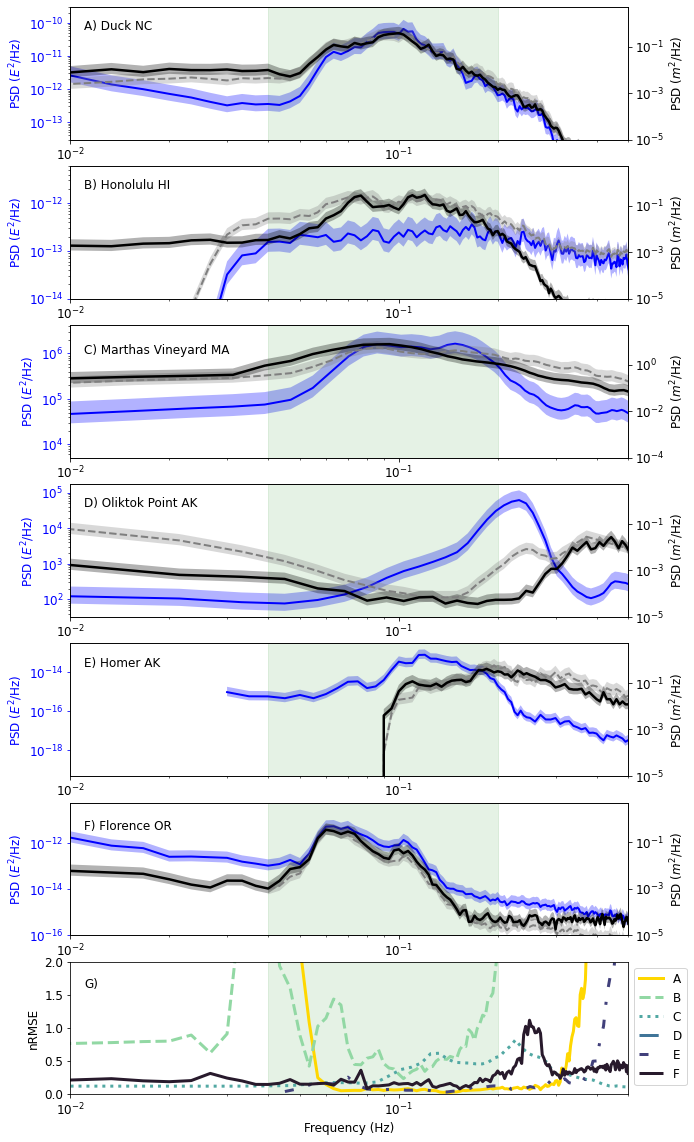

In [9]:
# format all of the example plots
for jj in range(6):
    ax[jj].set_xscale('log')
    ax[jj].set_yscale('log')
    ax[jj].set_xlim([0.01,0.5])
    ax[jj].set_ylabel('PSD ($E^2$/Hz)')
    ax[jj].yaxis.label.set_color('b')
    ax[jj].tick_params(axis='y', colors='b')
    ax[jj].axvspan(0.04, 0.2, alpha=0.1, color='g')


jj = 6
plt.rcParams['lines.linewidth'] = 3
ax[jj].plot(frq_p0,nrmse0,'-',label='A',c = 'gold')
ax[jj].plot(frq_p1,nrmse1,'--',label='B',c = clrs[1,:])
ax[jj].plot(frq_p2,nrmse2,':',label='C',c = clrs[2,:])
ax[jj].plot(frq_p3,nrmse3,'-.',label='D',c = clrs[3,:])
ax[jj].plot(frq_p4,nrmse4,label='E',c = clrs[4,:],linestyle=(0,(3,5,1,5)))
ax[jj].plot(frq_p5,nrmse5,label='F',c = clrs[5,:],linestyle=(0,(2,0)))

ax[jj].set_xscale('log')
ax[jj].set_xlim([0.01,0.5])
ax[jj].axvspan(0.04, 0.2, alpha=0.1, color='g')
ax[jj].set_ylim([0,2])
# ax[jj].legend()
ax[jj].set_ylabel('nRMSE')
ax[jj].set_xlabel('Frequency (Hz)')


xloc = 0.011
ax[0].text(xloc,6e-11, 'A) Duck NC')
ax[1].text(xloc,2e-12, 'B) Honolulu HI')
ax[2].text(xloc,1e6, 'C) Martha''s Vineyard MA')
ax[3].text(xloc,4e4, 'D) Oliktok Point AK')
ax[4].text(xloc,2e-14, 'E) Homer AK')
ax[5].text(xloc,4e-12, 'F) Florence OR')
ax[6].text(xloc,1.6, 'G)')
ax[6].legend(ncol=1,loc='upper left',bbox_to_anchor=(1,1))

fig.savefig('/Users/hglover/Library/CloudStorage/Box-Box/CompareSpectralRMSE_FXX.svg')
plt.ion()
fig